In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 1e-4
EPS = 1e-10
T=5
device = 'cuda:0'

In [2]:
def train_instance(model, optimizer, data, n_ants):
    model.train()
    sum_loss = 0.0
    count = 0
    for pyg_data, distances in data:
        heu_vec = model(pyg_data)
        heu_mat = model.reshape(pyg_data, heu_vec) + EPS
        
        aco = ACO(
            n_ants=n_ants,
            heuristic=heu_mat,
            distances=distances,
            device=device,
            two_opt=True,
        )
    
        costs, log_probs = aco.sample()
        baseline = costs.mean()
        reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
        sum_loss += reinforce_loss
        count += 1

    sum_loss = sum_loss/count
    optimizer.zero_grad()
    sum_loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters = model.parameters(), max_norm = 1.0, norm_type = 2)
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat.cpu(),
        distances=distances.cpu(),
        device='cpu',
        two_opt=True,
        )
    costs, log_probs = aco.sample(inference = True)
    aco.run(n_iterations=T, inference = True)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def generate_traindata(count, n_node, k_sparse):
    for _ in range(count):
        instance = torch.rand(size=(n_node, 2), device=device)
        yield gen_pyg_data(instance, k_sparse=k_sparse, start_node=0)

def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer,
                batch_size = 1,
                ):
    for _ in range(steps_per_epoch):
        train_instance(net, optimizer, generate_traindata(batch_size, n_node, k_sparse), n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for data, distances in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, data, distances, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 3, test_size = None):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(n_node, k_sparse, device, start_node=0)
    if test_size is not None:
        val_list = val_list[:test_size]
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net, optimizer, batch_size=batch_size)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/tsp_2opt/tsp{n_node}.pt')

Learn heuristic for TSP20: 

total training duration: 282.87691354751587
epoch -1: (7.40858039855957, 6.238798184394836, 3.807492878437042)
epoch 0: (7.380494828224182, 6.099189677238464, 3.807492878437042)
epoch 1: (7.356411070823669, 6.12736668586731, 3.807492878437042)
epoch 2: (7.262267699241638, 6.058091340065002, 3.807492878437042)
epoch 3: (7.119029874801636, 5.941248388290405, 3.807492878437042)
epoch 4: (6.989111356735229, 5.764759511947632, 3.807492878437042)
epoch 5: (6.812141108512878, 5.651847920417786, 3.807492878437042)
epoch 6: (6.582758088111877, 5.404145727157593, 3.807492878437042)
epoch 7: (6.400578489303589, 5.267405195236206, 3.807492878437042)
epoch 8: (6.116386404037476, 5.049119620323181, 3.807492878437042)
epoch 9: (5.998503232002259, 5.0132674932479855, 3.807492878437042)
epoch 10: (5.754907665252685, 4.779993731975555, 3.807492878437042)
epoch 11: (5.583445534706116, 4.651283438205719, 3.807492878437042)
epoch 12: (5.401732692718506, 4.562301948070526, 3.8074928855895998)
epoch 13: (5.2

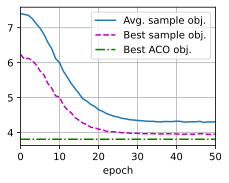

In [14]:
n_node, n_ants = 20, 20
k_sparse = 10
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=20)

total training duration: 279.73922657966614
epoch -1: (13.516677341461182, 11.875194206237794, 5.655122337341308)
epoch 0: (13.344203186035156, 11.608443698883057, 5.65800630569458)
epoch 1: (13.275028381347656, 11.558241863250732, 5.65714674949646)
epoch 2: (13.010415210723878, 11.371411323547363, 5.6598384571075435)
epoch 3: (12.803210620880128, 11.220352458953858, 5.65796856880188)
epoch 4: (12.468926372528076, 10.863601989746094, 5.657677221298218)
epoch 5: (12.137137317657471, 10.587654991149902, 5.656969881057739)
epoch 6: (11.734306545257569, 10.184694252014161, 5.658113660812378)
epoch 7: (11.283168830871581, 9.887488021850587, 5.657231845855713)
epoch 8: (10.86482702255249, 9.422938213348388, 5.657020225524902)
epoch 9: (10.532415313720703, 9.124656143188476, 5.659227027893066)
epoch 10: (10.137679500579834, 8.85799222946167, 5.656765127182007)
epoch 11: (9.682176418304444, 8.374843397140502, 5.656562414169311)
epoch 12: (9.296350917816163, 8.01334246635437, 5.655198383331299)

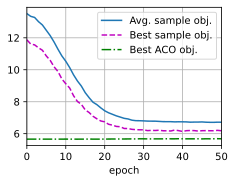

In [5]:
n_node, n_ants = 50, 30
k_sparse = 15
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=10)

Learn heuristic for TSP100: 

total training duration: 308.23534297943115
epoch -1: (21.366414222717285, 19.580006942749023, 7.913446636199951)
epoch 0: (21.201078300476073, 19.366749973297118, 7.926609544754029)
epoch 1: (20.99861520767212, 19.108205184936523, 7.93302478313446)
epoch 2: (20.657752513885498, 18.915520248413085, 7.929362306594848)
epoch 3: (20.144521465301512, 18.268779010772704, 7.933084735870361)
epoch 4: (19.594826107025145, 17.899992027282714, 7.917945456504822)
epoch 5: (19.193569831848144, 17.522624998092653, 7.9185692405700685)
epoch 6: (18.457555084228517, 16.793116722106934, 7.919454970359802)
epoch 7: (17.943999423980713, 16.307771129608156, 7.921717486381531)
epoch 8: (17.227351722717284, 15.603411178588868, 7.912837619781494)
epoch 9: (16.521196870803834, 14.986891880035401, 7.91248420715332)
epoch 10: (15.997336978912353, 14.466478624343871, 7.901056580543518)
epoch 11: (15.323557300567627, 13.847504587173463, 7.897655653953552)
epoch 12: (14.662942218780518, 13.270018844604492, 7.89760

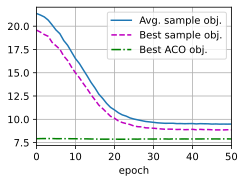

In [6]:
n_node = 100
n_ants = 20
k_sparse = 20
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=10)

total training duration: 898.6323666572571
epoch -1: (40.20054344177246, 37.907602081298826, 12.617803173065186)
epoch 0: (39.84861602783203, 37.45537406921387, 12.605162258148193)
epoch 1: (39.43312217712403, 37.18857925415039, 12.511347465515136)
epoch 2: (38.87926856994629, 36.48604461669922, 12.417119865417481)
epoch 3: (37.89415786743164, 35.53203300476074, 12.294901008605956)
epoch 4: (36.83275062561035, 34.59585685729981, 12.174737243652343)
epoch 5: (35.63103073120117, 33.5023157119751, 12.0039701461792)
epoch 6: (34.265029296875, 32.1039376449585, 11.807328033447266)
epoch 7: (32.88236747741699, 30.686104888916017, 11.714456329345703)
epoch 8: (31.638394088745116, 29.530313186645508, 11.605142993927002)
epoch 9: (30.13238338470459, 28.0227433013916, 11.471629695892334)
epoch 10: (28.671098823547364, 26.79418369293213, 11.408862781524657)
epoch 11: (27.169832000732423, 25.217357482910156, 11.318928470611572)
epoch 12: (25.818297882080078, 23.939928512573243, 11.289262104034425)

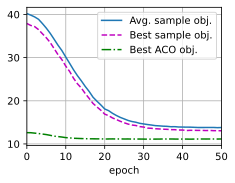

In [7]:
n_node = 200
n_ants = 20
k_sparse = 40
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=10)

Learn heuristic for TSP500: 

total training duration: 1992.632440328598
epoch -1: (69.0007308959961, 66.23641548156738, 38.408597755432126)
epoch 0: (68.51552925109863, 65.73895721435547, 38.040616798400876)
epoch 1: (67.67527046203614, 64.6518539428711, 37.62023220062256)
epoch 2: (66.62187805175782, 64.0488842010498, 36.866146850585935)
epoch 3: (64.85092067718506, 61.896494483947755, 35.62507514953613)
epoch 4: (62.94474639892578, 60.27016639709473, 34.27689743041992)
epoch 5: (60.352437019348145, 57.5649600982666, 32.81786479949951)
epoch 6: (57.63456554412842, 54.90091609954834, 31.202138805389403)
epoch 7: (55.473886489868164, 52.76001739501953, 29.931941413879393)
epoch 8: (52.76703853607178, 50.20205287933349, 28.374661350250243)
epoch 9: (50.65626220703125, 48.089202880859375, 27.235149765014647)
epoch 10: (48.327008438110354, 45.657229042053224, 26.16490936279297)
epoch 11: (47.08227424621582, 44.48589458465576, 25.534514141082763)
epoch 12: (44.40970039367676, 41.994136047363284, 24.23297119140625)
epoc

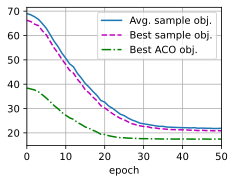

In [7]:
n_node = 500
n_ants = 100
k_sparse = 50
steps_per_epoch = 16
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 5, test_size=20)

total training duration: 1570.2963783740997
epoch -1: (189.387939453125, 184.78388671875, 135.45687103271484)
epoch 0: (181.4689682006836, 177.02191619873048, 130.3833251953125)
epoch 1: (163.94306640625, 159.38739318847655, 116.84649429321288)
epoch 2: (141.20537109375, 137.03512725830078, 99.14768753051757)
epoch 3: (118.078564453125, 114.6119369506836, 80.78743591308594)
epoch 4: (96.2896598815918, 92.94920806884765, 64.64450187683106)
epoch 5: (76.40900421142578, 73.30772018432617, 51.14840888977051)
epoch 6: (58.74633979797363, 56.19254913330078, 38.65879402160645)
epoch 7: (48.75830078125, 46.34221000671387, 32.20771808624268)
epoch 8: (43.594905853271484, 41.44316635131836, 29.623193168640135)
epoch 9: (41.17660064697266, 39.23345375061035, 28.08162612915039)
epoch 10: (38.67454452514649, 36.80472373962402, 27.35507583618164)
epoch 11: (37.877597427368165, 35.984079360961914, 27.02573928833008)
epoch 12: (36.95260162353516, 34.880057144165036, 26.71637134552002)
epoch 13: (36.54

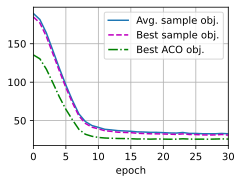

In [5]:
n_node = 1000
n_ants = 20
k_sparse = 200
steps_per_epoch = 50
epochs = 30
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 2, test_size = 10)

In [ ]:
n_node = 2000
n_ants = 20
k_sparse = 400
steps_per_epoch = 50
epochs = 30
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 1, test_size = 10)